# Figure 1 

Open walk network

In [149]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import networkx as nx
from latticeproteins.sequences import hamming_distance

In [150]:
def ring_levels(G, root):
    levels = dict([(i,[]) for i in range(20)])
    levels[0].append(root)
    for node in G.nodes():
        neighbors = G.neighbors(node)
        for neigh in neighbors:
            key = hamming_distance(root, neigh)
            levels[key].append(neigh)
    for key, val in levels.items():
        levels[key] = set(val)
    return levels

def radial(r, theta):
    return (r*np.cos(theta), r*np.sin(theta))

def ring_position(G, root):
    import random
    levels = ring_levels(G, root)
    pos = {}
    for i in range(len(levels)):
        nodes = levels[i]
        nodelist = list(nodes)
        random.shuffle(nodelist)
        rotate_translate = random.random()
        for j, node in enumerate(nodelist):
            angle = 2*np.pi / len(nodes)
            pos[node] = radial(i, j*angle + + rotate_translate)
    return pos


def modified_Gdiff(G0, G2):
    # Get a dictionary of change in fluxes along each edge.
    edges_0 = dict([((i, j), G0.edge[i][j]["delta_flux"]) for i,j in G0.edges()])
    edges_2 = dict([((i, j), G2.edge[i][j]["delta_flux"]) for i,j in G2.edges()])

    # -----------------------------------------------
    # Calculate the change in delta_flux on each edge
    # -----------------------------------------------
    edges_diff = {}
    # See what edges we lost
    for key, val in edges_0.items():
        if key in edges_2:
            weight = edges_2[key] - edges_0[key]
            if weight < 0:
                # This edge gained flux
                color = "r"
            else:
                # This edge lost flux
                color = "b"
            edges_diff[key] = dict(color=color, weight=abs(weight))
        else:
            # This edge was lost in our predictions
            edges_diff[key] = dict(weight=val, color="r")

    # See what edges we gained.
    for key, val in edges_2.items():
        if key in edges_0:
            pass
        else:
            # This edge was gained in our predictions
            edges_diff[key] = dict(weight=val, color="b")

    # -----------------------------------------------
    # Calculate the change in flux at each node
    # -----------------------------------------------
    nodes_0 = dict([(i, G0.node[i]["flux"]) for i in G0.nodes()])
    nodes_2 = dict([(i, G2.node[i]["flux"]) for i in G2.nodes()])

    node_diff = {}
    for key, val in nodes_0.items():
        if key in nodes_2:
            diff = nodes_2[key] - val
            if diff > 0:
                color = "b"
            else:
                color = "r"
            node_diff[key] = dict(color=color, outer=nodes_2[key], inner=val)
        else:
            node_diff[key] = dict(color="r", outer=nodes_0[key], inner=0)

    for key, val in nodes_2.items():
        if key in nodes_0:
            pass
        else:
            node_diff[key] = dict(color="b", outer=val, inner=0)

    # -----------------------------------------------
    # Construct a network of differences
    # -----------------------------------------------
    Gdiff = nx.DiGraph()
    for key, val in edges_diff.items():
        Gdiff.add_edge(key[0],key[1],**val)

    for key, val in node_diff.items():
        Gdiff.node[key].update(**val)

    return Gdiff


def plot_networks(G1, G2, source, path):
    """"""
    # options
    node_scale = 600
    edge_scale = 40
    node_color = "k"
    

    # Remove nodes that have small flux
    nodes_to_remove = []
    for node in G1.nodes():
        if G1.node[node]["flux"] < 0.01:
            nodes_to_remove.append(node)

    nodes_to_remove2 = []
    for node in G2.nodes():
        if G2.node[node]["flux"] < 0.01:
            nodes_to_remove2.append(node)
        
    G1.remove_nodes_from(nodes_to_remove)
    G2.remove_nodes_from(nodes_to_remove2)
    Gdiff = modified_Gdiff(G1, G2)

    from matplotlib.gridspec import GridSpec
    from matplotlib.patches import Circle
    
    def draw_circles(ax):
        """Draw circles add increasing hamming distances for each network."""
        for i in range(0,8):
            circle = Circle((0, 0), i, facecolor='none',
                    edgecolor="k", linewidth=.5, alpha=0.5, linestyle="--")
            ax.add_patch(circle)

    
    # Initialize a figure
    fig = plt.figure(figsize=(20,8))
    
    # Initialize a gridspec
    gs = GridSpec(1, 3)
       
    seq = source
    # Calculate the positions for all nodes on rings
    pos = ring_position(Gdiff, seq)

    # -------------------------------------------------
    # Draw the first network
    # -------------------------------------------------
    
    ax1 = plt.subplot(gs[0, 0])
    
    # Set the widths of the edges to the delta flux attribute of each edge.
    edge_widths = np.array([G1.edge[i][j]["delta_flux"] for i,j in G1.edges()])
    edge_widths = edge_widths * edge_scale
    #edge_widths = np.ma.log10(edge_widths).filled(0) * edge_scale
    nx.draw_networkx_edges(G1, pos=pos, ax=ax1,
        width=edge_widths,                
        arrows=False,
        edge_color="gray",
        alpha=0.5
    )
    
    # Set the node sizes to the amount of flux passing through each node.
    node_size = [G1.node[i]["flux"] * node_scale for i in G1.nodes()]
    #node_size = np.ma.log10(node_size).filled(0)

    nx.draw_networkx_nodes(G1, pos=pos, ax=ax1,
        node_size=node_size,                
        linewidths=None,
        node_color=node_color
    )
    
    bad_nodes1 = [node for node in Gdiff.nodes() if node not in G1.nodes()]
    bad_nodes1_size = [G2.node[node]["flux"] * node_scale for node in Gdiff.nodes() if node not in G1.nodes()]

    nx.draw_networkx_nodes(Gdiff, pos=pos, ax=ax1,
        nodelist = bad_nodes1,
        node_shape = "x",
        node_size = bad_nodes1_size,
        linewidths = None,
        node_color = "m"
    )
    
    # Draw circles
    draw_circles(ax1)
    ax1.axis("equal")
    ax1.axis("off")
    
    # -------------------------------------------------
    # Draw the second network
    # -------------------------------------------------
    
    ax2 = plt.subplot(gs[0, 1])

    
    # Set the widths of the edges to the delta flux attribute of each edge.
    edge_widths = np.array([G2.edge[i][j]["delta_flux"] for i,j in G2.edges()])
    edge_widths = edge_widths * edge_scale
    #edge_widths = np.ma.log10(edge_widths).filled(0) * edge_scale
    nx.draw_networkx_edges(G2, pos=pos, ax=ax2,
        width=edge_widths,                
        arrows=False,
        edge_color="gray",
        alpha=0.5
    )
    
    # Set the node sizes to the amount of flux passing through each node.
    node_size = [G2.node[i]["flux"] * node_scale for i in G2.nodes()]
    #node_size = np.ma.log10(node_size).filled(0)

    nx.draw_networkx_nodes(G2, pos=pos, ax=ax2,
        node_size=node_size,                
        linewidths=None,
        node_color=node_color
    )

    bad_nodes2 = [node for node in Gdiff.nodes() if node not in G2.nodes()]
    bad_nodes2_size = [G1.node[node]["flux"] * node_scale for node in Gdiff.nodes() if node not in G2.nodes()]

    nx.draw_networkx_nodes(Gdiff, pos=pos, ax=ax2,
        nodelist = bad_nodes2,
        node_shape = "x",
        node_size = bad_nodes2_size,
        linewidths = None,
        node_color = "m"
    )
        
    # Draw circles
    draw_circles(ax2) 
    ax2.axis("equal")
    ax2.axis("off")
    
    # -------------------------------------------------
    # Draw difference network
    # -------------------------------------------------
        
    ax3 = plt.subplot(gs[0, 2])

    
    # Set the widths of the edges to the delta flux attribute of each edge.
    edge_widths = np.array([Gdiff.edge[i][j]["weight"] for i,j in Gdiff.edges()])
    edge_widths = edge_widths * edge_scale
    #edge_widths = np.ma.log10(edge_widths).filled(0) * edge_scale 
    edge_color = [Gdiff.edge[i][j]["color"] for i,j in Gdiff.edges()]

    nx.draw_networkx_edges(Gdiff, pos=pos, ax=ax3,
        width=edge_widths,                
        arrows=False,
        edge_color=edge_color,
        alpha=0.5
    )
    
    # Set the node sizes to the amount of flux passing through each node.
    node_size = [Gdiff.node[i]["outer"] * node_scale for i in Gdiff.nodes()]
    node_color = [Gdiff.node[i]["color"]  for i in Gdiff.nodes()]
    nx.draw_networkx_nodes(Gdiff, pos=pos, ax=ax3,
        node_size=node_size,                
        linewidths=None,
        node_color=node_color
    )

    # Set the node sizes to the amount of flux passing through each node.
    node_size = [Gdiff.node[i]["inner"] * node_scale for i in Gdiff.nodes()]
    nx.draw_networkx_nodes(Gdiff, pos=pos, ax=ax3,
        node_size=node_size,                
        linewidths=None,
        node_color="w"
    )    
    
    # Draw circles
    draw_circles(ax3) 

    ax3.axis("equal")
    ax3.axis("off")
    return fig

* 3
* 6
* 11
* 17
* 26
* 29!
* 44
* 45
* 99

WIKSKCMFCSWH


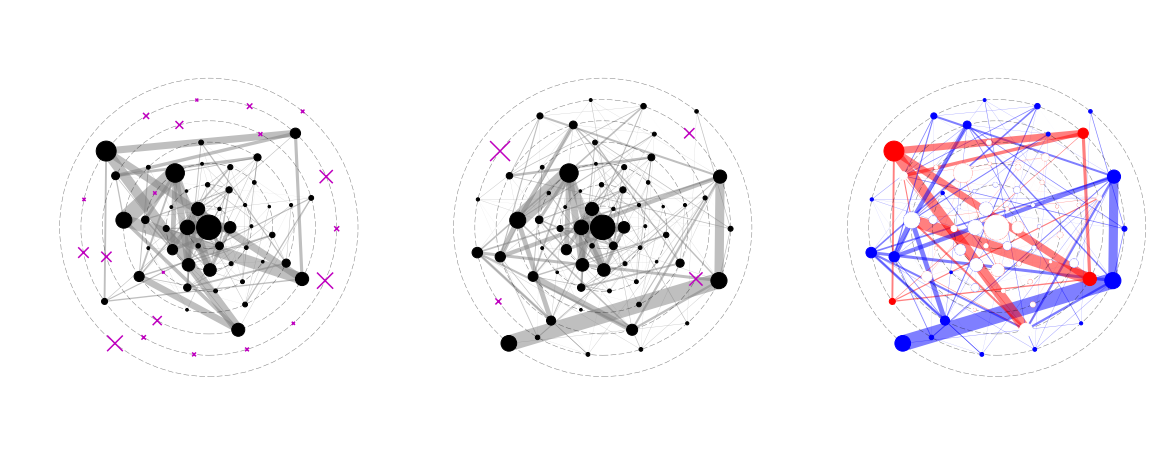

In [204]:
dataset = "full-state-predictions"
number = 29

filepath = "generated-data/%s/results-old/networks-%d.pickle" % (dataset, number)

with open(filepath, "rb") as f:
    data = pickle.load(f)
    Gactual = data["Gactual"]
    Gpredict = data["Gpredict"]
    Gdiff = data["Gdiff"]
    seq= data["seq"]
    print(seq)
    
fig = plot_networks(Gactual, Gpredict, seq)

In [147]:
fig.savefig("figures/network-%s.pdf" % seq, format="pdf", bbox_inches="tight")

In [153]:
"WIKSKCMFCSWH"

'WIKSKCMFCSWH'

In [154]:
def top_path(G, source):
    # Find moves away from center
    rings = ring_levels(G, source)
    # Get further derived sequences
    for i in range(7):
        if len(rings[i]) != 0:
            furthest = i
    ends = rings[furthest] # only 6 moves away

    # Build a dictionary of node flux to
    options = dict([(end, G.node[end]['flux']) for end in ends])

    sequences = np.array(list(options.keys()))
    fluxes = np.array(list(options.values()))

    # Find the highest flux sequence
    most_probable_node = np.argmax(fluxes)

    max_seq = sequences[most_probable_node]

    # Return that sequence
    return (source, max_seq)

In [164]:
wt1, mut1 = top_path(Gactual, "WIKSKCMFCSWH")

In [165]:
wt2, mut2 = top_path(Gpredict, "WIKSKCMFCSWH")

In [160]:
from latticegpm.gpm import LatticeGenotypePhenotypeMap
from latticeproteins.conformations import Conformations

In [162]:
c = Conformations(12)

In [171]:
space1 = LatticeGenotypePhenotypeMap.from_mutant('WIKSKCMFCSWH', 'WWKWDCMMCKWM', Conformations=c)
space1.phenotype_type = "stabilities"
map1 = space1.map("genotypes", "phenotypes")
print(map1[wt1], map1[mut1])
print(wt1, mut1)

-2.18403071396 -2.71955269212
WIKSKCMFCSWH WWKWDCMMCKWM


In [ ]:
map1 = space1.map("genotypes", "phenotypes")
map1[wt1], map1[mut1]

In [172]:
import networkx as nx

In [182]:
path = nx.all_shortest_paths(Gactual, wt1, mut1)

In [183]:
x = list(path)

In [185]:
print(len(x))

36


In [186]:
sflux = 0
for path in x:
    flux = []
    for p in path:
        flux.append(Gactual.node[p]["flux"])
    if sum(flux) > sflux:
        sflux = sum(flux)
        winner = path

In [199]:
for p in path:
    print(p, map1[p])

WIKSKCMFCSWH -2.18403071396
WWKSKCMFCSWH -2.33038567446
WWKWKCMFCSWH -2.46529176553
WWKWKCMMCSWH -2.59367514755
WWKWKCMMCSWM -2.69511870407
WWKWDCMMCSWM -2.713760769
WWKWDCMMCKWM -2.71955269212


In [ ]:
fig = plot_networks(Gactual, Gpredict, seq, path)

In [195]:

def ring_levels(G, root):
    levels = dict([(i,[]) for i in range(20)])
    levels[0].append(root)
    for node in G.nodes():
        neighbors = G.neighbors(node)
        for neigh in neighbors:
            key = hamming_distance(root, neigh)
            levels[key].append(neigh)
    for key, val in levels.items():
        z = sorted(list(set(val)))
        levels[key] = z
    return levels

rings = ring_levels(Gdiff, seq)
running_denom = 0
running_diff = 0

# Add to summary statistic
for ring, sequences in rings.items():

    if  ring < 8:

        diff, denom1, denom2 = 0, 0, 0
        for i in sequences:

            # Add up total flux exchange, and the difference between two networks
            for j in Gdiff.neighbors(i):

                diff += Gdiff.edge[i][j]["weight"]
                try: denom1 += Gactual.edge[i][j]["delta_flux"]
                except: pass

                try: denom2 += Gpredicted.edge[i][j]["delta_flux"]
                except: pass

        denom = denom1 + denom2
        #print(d, ring, denom, diff, seq)
        # Normalize the flux exchange at this hamming distance
        running_diff += diff
        running_denom += denom


In [198]:
running_diff / running_denom

0.66350381520094626